<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 38

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [9]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from zipfile import ZipFile
import requests
import io
import torch
import torch.nn as nn

c:\Users\20172648\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [36]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [12]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [13]:
print(p.shape)

(2,)


In [75]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [76]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

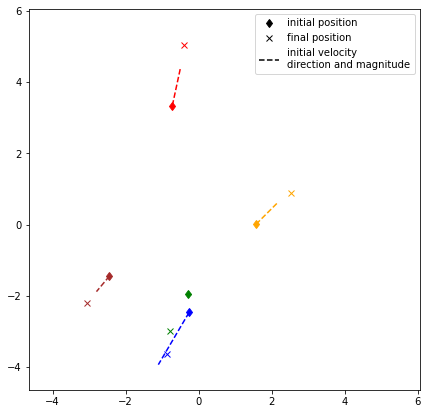

In [78]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [88]:
# todo: Dataloader for velocity, charges, position in 1 dataset class
from torch.utils.data import Dataset, DataLoader,TensorDataset
class MyDataset(Dataset):
    def __init__(self, veloc, pos, charges):
        self.velocity = torch.FloatTensor(veloc)
        self.charges = torch.FloatTensor(charges)
        self.position = torch.FloatTensor(pos)
 
    def __getitem__(self, index):
        x = self.velocity[index]
        y = self.charges[index]
        z = self.position[index]
        return x, y, z
        # outputs list of 3 128 batches
        # so [tensor(128, 1 , 4, 5), tensor(128, 1, 5)....]
    def __len__(self):
        return len(self.charges)

In [89]:
train_dataset=MyDataset(velocities_train, positions_train, charges_train)
val_dataset = MyDataset(velocities_valid, positions_valid, charges_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)

In [90]:
# check data
for veloc, charges, position in train_loader:
    print(veloc.shape, position.shape, charges.shape)
    print("veloc {sim, init_vel, x or y, ptxid} -  charge {sim, ptxid, charge} - pos {sim, time, x or y, ptxd}")
    print("initial velocity",  veloc[0, 0, :, 0])
    print("initial position", position[0, 0, :, 0])
    print(charges[0, 0, 0])
    # we need to predict from init velocity
    break

torch.Size([128, 1, 2, 5]) torch.Size([128, 4, 2, 5]) torch.Size([128, 5, 1])
veloc {sim, init_vel, x or y, ptxid} -  charge {sim, ptxid, charge} - pos {sim, time, x or y, ptxd}
initial velocity tensor([-0.7878,  0.0267])
initial position tensor([-1.9361, -0.2276])
tensor(-1.)


# Model Implementation

In [113]:
#todo
# pass veloc, pos from t =0  to predict
count = 0 
for veloc, charges, position in train_loader:
    v = veloc[0, 0, :, 0]
    p = position[0, 0, :, 0]
    c = charges[0, 0, 0]
    print(torch.cat([v, p, c.view(1)], dim=0))
    break

tensor([-0.7878,  0.0267, -1.9361, -0.2276, -1.0000])


In [116]:
# Simple NN network for value prediction
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_dim,5)
        self.layer2 = nn.Linear(5, 5)
        self.layer3 = nn.Linear(5, 1)
        # self.drop = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        # x = self.drop(x)
        x = F.relu(self.layer2(x))
        # x = self.drop(x)
        x = F.relu(self.layer3(x))
        return x

In [21]:
# LSTmodel RNN
# NOT FINISHED
#####
#https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
####
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [94]:
import torch.optim as optim

input_dim = 3 #len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
RNN_network = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)
optimizer = optim.Adam(RNN_network.parameters(), lr=learning_rate, weight_decay=weight_decay)

# for veloc, position, charges in train_loader:
#     RNN_network(veloc[0, 0, :, 0])
#     break

# Model Training REGULAR NEURAL NET

In [122]:
# NN MODEL
def train(model, train_loader, batch_size, n_epochs, optimizer, criterion):
    best_val_loss = float("Inf") 
    epoch_best = 0
    epoch_val_best = 0
    train_losses = []
    for epoch in range(1, n_epochs + 1):
        running_loss = 0.0
        model.train()

        for veloc, charges, position in train_loader:
            try:
                for sim in range(batch_size):
                    pt_loss = 0.0
                    for ptxid in range(5):
                        init_veloc_xy = veloc[sim, 0, (0,1), ptxid] # list
                        init_pos_xy = position[sim, 0, (0,1), ptxid] #list
                        charge = charges[sim, ptxid, 0]
                        x = torch.cat([init_pos_xy, init_veloc_xy, charge.view(1)], dim=0)
                        y = position[sim, 1, (0,1), ptxid]
                        outputs = model(x)
                        loss = criterion(outputs, y)
                        pt_loss += loss.item()
                        loss.backward()
                        optimizer.step()
                    pt_loss = pt_loss/5
                    running_loss += pt_loss
            except IndexError:
                for sim in range(16):
                    pt_loss = 0.0
                    for ptxid in range(5):
                        init_veloc_xy = veloc[sim, 0, (0,1), ptxid] # initial velocity per sim per particle
                        init_pos_xy = position[sim, 0, (0,1), ptxid] # initial position per sim per particle
                        charge = charges[sim, ptxid, 0] # charge per sim per particle 
                        x = torch.cat([init_pos_xy, init_veloc_xy, charge.view(1)], dim=0) # make 1 tensor of it 
                        y = position[sim, 1, (0,1), ptxid] # y_actual (position at time t=0.5)
                        outputs = model(x)
                        loss = criterion(outputs, y)
                        pt_loss += loss.item()
                        loss.backward()
                        optimizer.step()
                    pt_loss = pt_loss/5
                    running_loss += pt_loss
                    
        avg_train_loss = running_loss / len(train_loader) * 128 # batch size
        train_losses.append(avg_train_loss)
        # training_loss = np.mean(batch_losses)
        # self.train_losses.append(training_loss)

        # with torch.no_grad():
        #     batch_val_losses = []
        #     for x_val, y_val in val_loader:
        #         #x_val = x_val.view([batch_size, -1, n_features]).to(device)
        #         y_val = y_val.to(device)
        #         self.model.eval()
        #         yhat = self.model(x_val)
        #         val_loss = self.loss_fn(y_val, yhat).item()
        #         batch_val_losses.append(val_loss)
        #     validation_loss = np.mean(batch_val_losses)
        #     self.val_losses.append(validation_loss)

        # if (epoch <= 10) | (epoch % 50 == 0):
        #     print(
        #         f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
        #     )

    return train_losses

In [123]:
model = SimpleModel(input_dim=5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainloss = train(model= model, train_loader= train_loader, batch_size=128, n_epochs=1, optimizer= optimizer, criterion=loss_fn)

c:\Users\20172648\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [124]:
trainloss

[120346.36929627771]

# Evaluation

In [ ]:
#todo